## Split the dataset into training, validation and test set 

- 70% training set
- 15% validation set
- 15% test set



In [1]:

from sklearn.model_selection import train_test_split
import pathlib
import tensorflow as tf
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

2024-05-07 16:53:55.778354: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 16:53:55.808674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 16:53:56.376391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(698, 2)


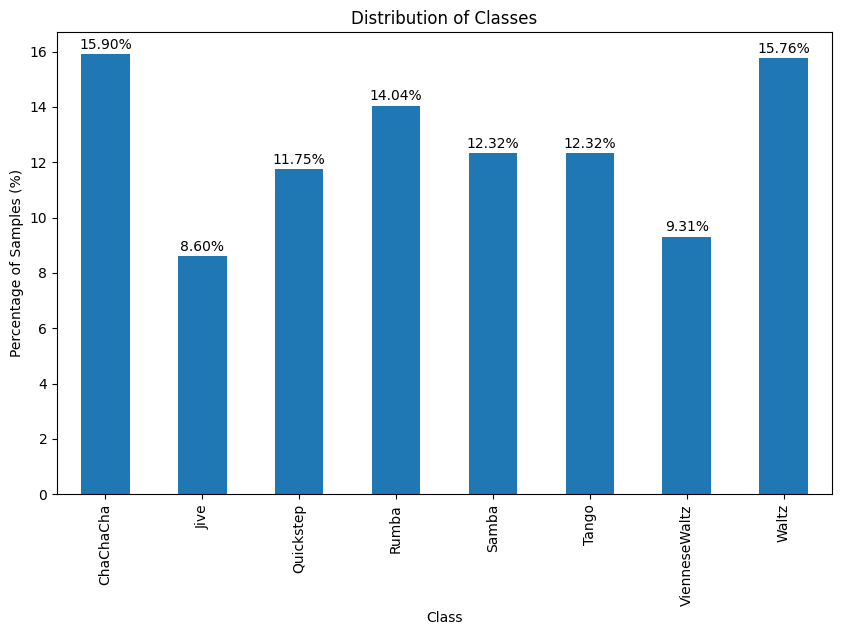

In [2]:
DATASET_PATH = 'wavfiles'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]

df = pd.DataFrame(columns=['song', 'label'])

# Get all .wav files from the dataset path
df['song'] = glob.glob(str(data_dir / '**/*.wav'))
df['label'] = df['song'].apply(lambda x: x.split('/')[-2])


X = df['song']
y = df['label']

print(df.shape)
# Plotting the number of samples per class
class_counts = df['label'].value_counts().sort_index()
total_samples = class_counts.sum()
percentage_counts = (class_counts / total_samples) * 100

plt.figure(figsize=(10, 6))
percentage_counts.plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage of Samples (%)')
for i, v in enumerate(percentage_counts):
    plt.text(i, v + 0.2, f"{v:.2f}%", color='black', ha='center')
plt.show()


In [3]:

# Split the dataset into training and a temporary set (85% train, 15% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, stratify=y)

# Now split the temporary set into validation and test sets (50% validation, 50% test from the temp set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

print("X_train:", len(X_train))
print("X_val:", len(X_val))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_val:", len(y_val))
print("y_test:", len(y_test))

X_train: 593
X_val: 52
X_test: 53
y_train: 593
y_val: 52
y_test: 53


In [4]:
import pandas as pd

# Create a DataFrame for each subset
train_df = pd.DataFrame({'file_path': X_train, 'class': y_train, 'dataset': 'train'})
val_df = pd.DataFrame({'file_path': X_val, 'class': y_val, 'dataset': 'validation'})
test_df = pd.DataFrame({'file_path': X_test, 'class': y_test, 'dataset': 'test'})

# Concatenate all DataFrames
full_df = pd.concat([train_df, val_df, test_df])

# Save to CSV
full_df.to_csv('dataset_splits.csv', index=False)

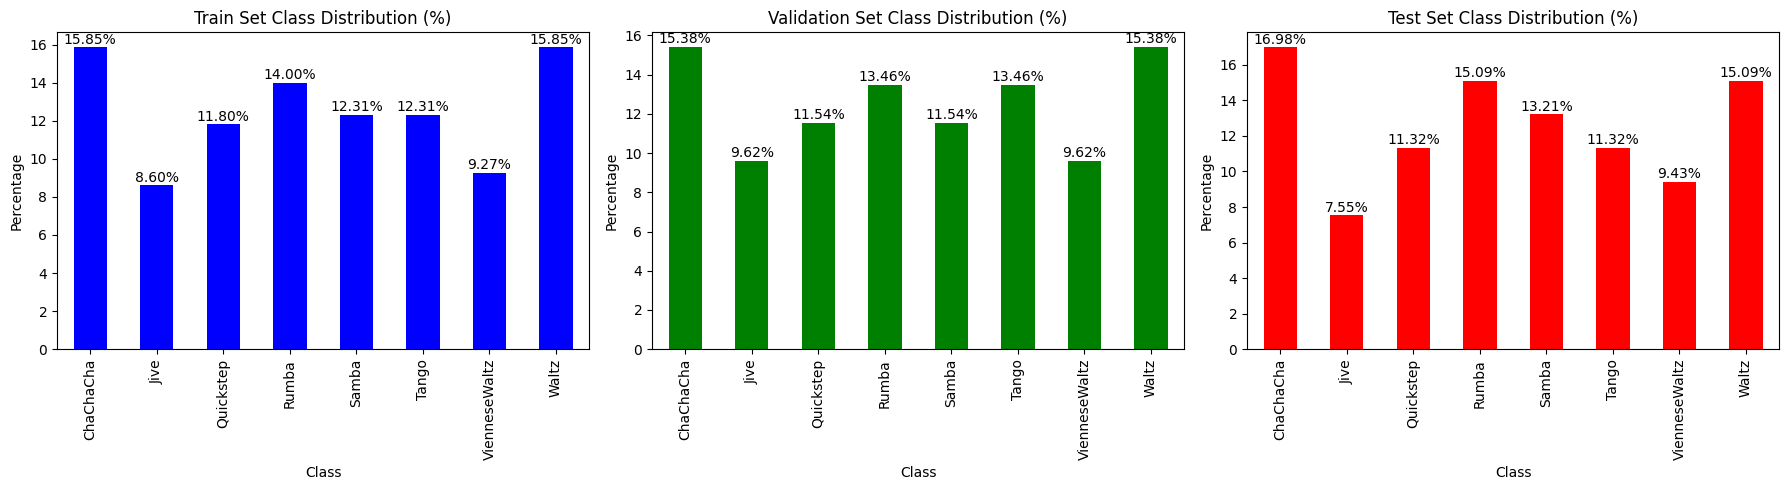

In [5]:
# Plotting the distribution of classes in the train, validation, and test sets in percentage
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Calculate percentages for train, validation, and test sets
train_percentage = y_train.value_counts(normalize=True).sort_index() * 100
val_percentage = y_val.value_counts(normalize=True).sort_index() * 100
test_percentage = y_test.value_counts(normalize=True).sort_index() * 100

# Train set distribution
train_percentage.plot(kind='bar', ax=axes[0], title='Train Set Class Distribution (%)', color='blue')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Percentage')
for i, v in enumerate(train_percentage):
    axes[0].text(i, v + 0.2, f"{v:.2f}%", color='black', ha='center')

# Validation set distribution
val_percentage.plot(kind='bar', ax=axes[1], title='Validation Set Class Distribution (%)', color='green')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage')
for i, v in enumerate(val_percentage):
    axes[1].text(i, v + 0.2, f"{v:.2f}%", color='black', ha='center')

# Test set distribution
test_percentage.plot(kind='bar', ax=axes[2], title='Test Set Class Distribution (%)', color='red')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Percentage')
for i, v in enumerate(test_percentage):
    axes[2].text(i, v + 0.2, f"{v:.2f}%", color='black', ha='center')

plt.tight_layout()
plt.show()


## Preprocessing audio files

1. downsample the audio files to 16000 Hz
2. split the audio files into 5 second chunks
3. mask the audio files to remove the noise
4. save the audio files to the wav files



In [6]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wavio
from librosa.core import resample, to_mono
from scipy.io import wavfile
from tqdm import tqdm

In [7]:
def envelope(y, rate, threshold):
    """
    Generate a mask for the audio signal based on a threshold.
    The mask is True where the rolling maximum of the absolute signal exceeds the threshold.
    
    Args:
    y (array): The audio signal.
    rate (int): The sample rate of the audio signal.
    threshold (float): The threshold value for the envelope.
    
    Returns:
    tuple: A tuple containing the mask array and the rolling maximum values (envelope).
    """
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate / 20), min_periods=1, center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

def downsample_mono(path, sr):
    """
    Read an audio file, convert it to mono if it is stereo, and downsample it to a given sample rate.
    
    Args:
    path (str): The file path of the audio file.
    sr (int): The target sample rate.
    
    Returns:
    tuple: A tuple containing the new sample rate and the downsampled audio data.
    """
    obj = wavio.read(path)
    wav = obj.data.astype(np.float32, order="F")
    rate = obj.rate
    try:
        channel = wav.shape[1]
        if channel == 2:
            wav = to_mono(wav.T)
        elif channel == 1:
            wav = to_mono(wav.reshape(-1))
    except IndexError:
        wav = to_mono(wav.reshape(-1))
    except Exception as exc:
        raise exc
    wav = resample(wav, orig_sr=rate, target_sr=sr)
    wav = wav.astype(np.int16)
    return sr, wav

def save_sample(sample, rate, target_dir, fn, ix):
    """
    Save a sample of audio data to a file.
    
    Args:
    sample (array): The audio data to save.
    rate (int): The sample rate of the audio data.
    target_dir (str): The directory where the audio file will be saved.
    fn (str): The base filename for the audio file.
    ix (int): The index of the sample, used to create a unique filename.
    """
    fn = fn.split(".wav")[0]
    dst_path = os.path.join(target_dir, fn + "_{}.wav".format(str(ix)))
    if os.path.exists(dst_path):
        return
    wavfile.write(dst_path, rate, sample)

def check_dir(path):
    """
    Check if a directory exists, and create it if it does not.
    
    Args:
    path (str): The path of the directory to check.
    """
    os.makedirs(path, exist_ok=True)

def split_wavs(file_paths, dst_root, sr, delta_time, threshold):
    """
    Process a list of audio files by downsampling, applying an envelope, and splitting into chunks.
    
    Args:
    file_paths (list): A list of file paths to process.
    dst_root (str): The root directory where processed files will be saved.
    sr (int): The sample rate to downsample to.
    delta_time (float): The duration in seconds of each audio chunk.
    threshold (float): The threshold used for the envelope function.
    """
    check_dir(dst_root)
    for path in tqdm(file_paths):
        rate, wav = downsample_mono(path, sr)
        mask, y_mean = envelope(wav, rate, threshold=threshold)
        wav = wav[mask]
        delta_sample = int(delta_time * rate)
        fn = os.path.basename(path)
        target_dir = os.path.join(dst_root, os.path.basename(os.path.dirname(path)))
        check_dir(target_dir)

        if wav.shape[0] < delta_sample:
            sample = np.zeros(shape=(delta_sample,), dtype=np.int16)
            sample[: wav.shape[0]] = wav
            save_sample(sample, rate, target_dir, fn, 0)
        else:
            trunc = wav.shape[0] % delta_sample
            for cnt, i in enumerate(np.arange(0, wav.shape[0] - trunc, delta_sample)):
                start = int(i)
                stop = int(i + delta_sample)
                sample = wav[start:stop]
                save_sample(sample, rate, target_dir, fn, cnt)


In [8]:
dst_root = 'clean'
delta_time = 5.0  # seconds
sr = 16000  # sample rate
threshold = 10  # threshold for envelope


split_wavs(X_train, os.path.join(dst_root, 'train'), sr, delta_time, threshold)
split_wavs(X_val, os.path.join(dst_root, 'val'), sr, delta_time, threshold)
split_wavs(X_test, os.path.join(dst_root, 'test'), sr, delta_time, threshold)

100%|██████████| 53/53 [00:03<00:00, 15.43it/s]


## Start to train a music classification model

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [10]:
import os

def list_audio_files(root_dir):
    """
    List all audio files in the directory structure starting from root_dir.
    Assumes subdirectories 'train', 'val', and 'test' under root_dir, each containing further subdirectories.
    """
    categories = ['train', 'val', 'test']
    audio_files = {}
    for category in categories:
        dir_path = os.path.join(root_dir, category)
        files = []
        for subdir, dirs, files_in_dir in os.walk(dir_path):
            for file in files_in_dir:
                if file.endswith('.wav'):
                    files.append(os.path.join(subdir, file))
        audio_files[category] = files
    return audio_files


audio_files = list_audio_files('clean')
print("Training files:", len(audio_files['train']))
print("Validation files:", len(audio_files['val']))
print("Testing files:", len(audio_files['test']))

Training files: 3845
Validation files: 574
Testing files: 562


In [11]:
import tensorflow as tf

# Define the directory paths for train, validation, and test sets
train_dir = os.path.join('clean', 'train')
val_dir = os.path.join('clean', 'val')
test_dir = os.path.join('clean', 'test')


# Create audio datasets using tf.keras.utils.audio_dataset_from_directory with labels
train_ds = tf.keras.utils.audio_dataset_from_directory(
    train_dir,
    output_sequence_length=int(sr * delta_time),  # Output sequence length
    batch_size=32,  # Example batch size
    shuffle=True  # Shuffle the data
)

val_ds = tf.keras.utils.audio_dataset_from_directory(
    val_dir,
    output_sequence_length=int(sr * delta_time),
    batch_size=32,
    shuffle=False  # Usually, we do not shuffle the validation data
)

test_ds = tf.keras.utils.audio_dataset_from_directory(
    test_dir,
    output_sequence_length=int(sr * delta_time),
    batch_size=32,
    shuffle=False
)

print("Train dataset:", train_ds)
print("Validation dataset:", val_ds)
print("Test dataset:", test_ds)

train_ds.element_spec

Found 3845 files belonging to 8 classes.


2024-05-07 16:54:42.341313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 16:54:42.368640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 16:54:42.368705: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 16:54:42.370581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 16:54:42.370626: I external/local_xla/xla/stream_executor

Found 574 files belonging to 8 classes.
Found 562 files belonging to 8 classes.
Train dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 80000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 80000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 80000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


(TensorSpec(shape=(None, 80000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [12]:
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


label names: ['ChaChaCha' 'Jive' 'Quickstep' 'Rumba' 'Samba' 'Tango' 'VienneseWaltz'
 'Waltz']


In [13]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [14]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 80000)
(32,)


2024-05-07 16:54:43.521138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
label_names[[1,1,3,0]]

array(['Jive', 'Jive', 'Rumba', 'ChaChaCha'], dtype='<U13')

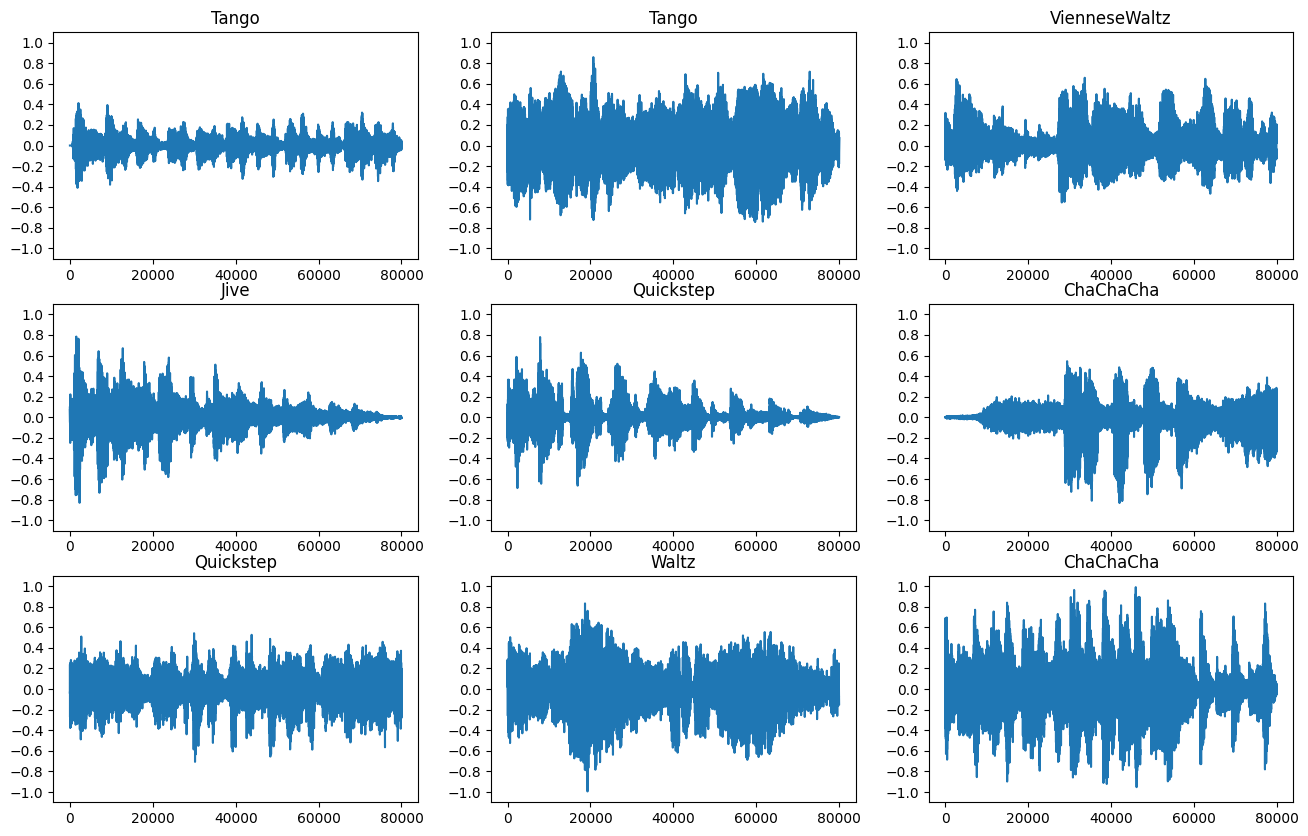

In [16]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])



In [17]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128,fft_length=512)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [18]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: Tango
Waveform shape: (80000,)
Spectrogram shape: (624, 257, 1)
Audio playback


Label: Tango
Waveform shape: (80000,)
Spectrogram shape: (624, 257, 1)
Audio playback


Label: VienneseWaltz
Waveform shape: (80000,)
Spectrogram shape: (624, 257, 1)
Audio playback


In [19]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

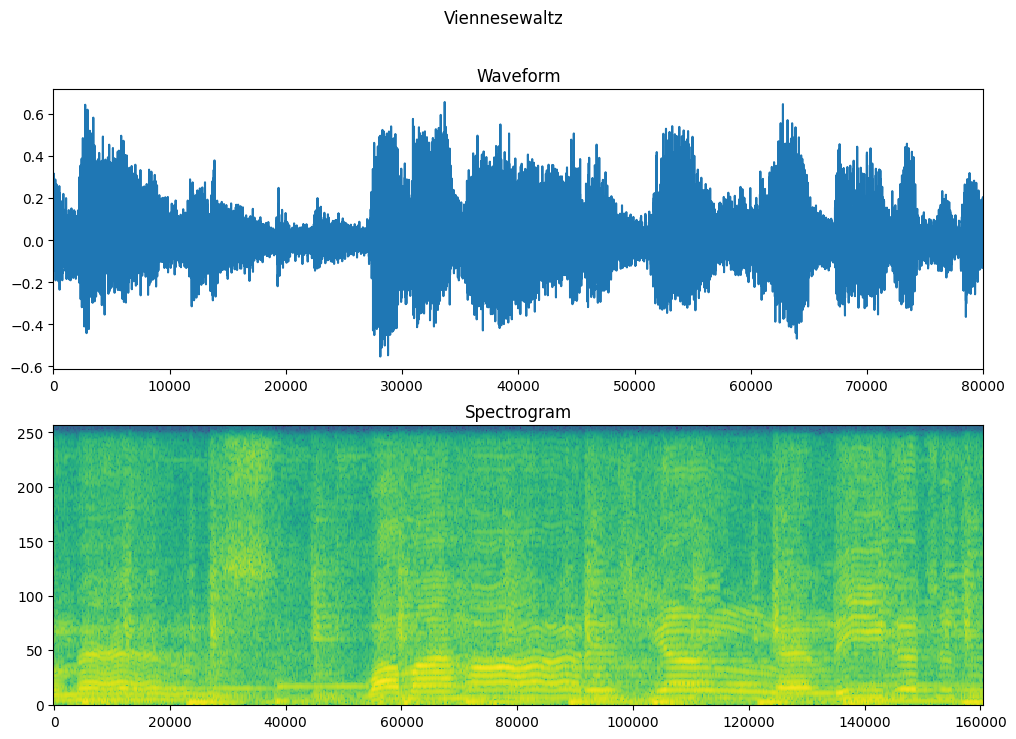

In [20]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 80000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [21]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

In [22]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [23]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

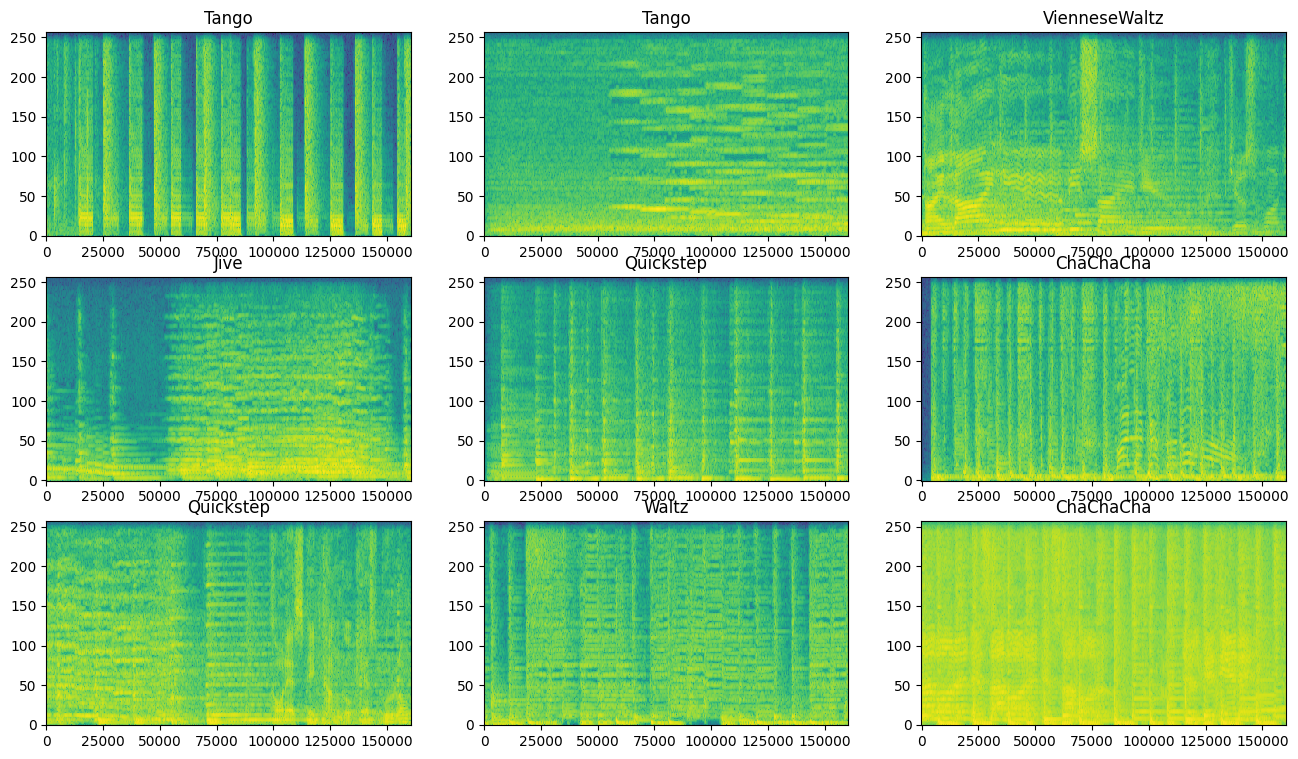

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_labels[i]])

plt.show()



In [25]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Resizing(64, 64),
    # layers.Normalization(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2, padding='same'),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2, padding='same'),
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2, padding='same'),
    layers.Dropout(0.3),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2, padding='same'),
    layers.Dropout(0.35),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2, padding='same'),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    # Final layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (624, 257, 1)


2024-05-07 16:54:49.167729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 624, 257, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,625,163 (10.01 MB)

 Trainable params: 2,623,176 (10.01 MB)

 Non-trainable params: 1,987 (7.77 KB)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    run_eagerly=True,
)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
BATCH_SIZE=32

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.0001)



history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)



Epoch 1/100


2024-05-07 16:54:49.926083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.2206 - loss: 3.9347 - val_accuracy: 0.1220 - val_loss: 5.8258 - learning_rate: 0.0010
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.3539 - loss: 2.3534 - val_accuracy: 0.1150 - val_loss: 17.4045 - learning_rate: 0.0010
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.4356 - loss: 2.1441 - val_accuracy: 0.1150 - val_loss: 25.5815 - learning_rate: 0.0010
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.4634 - loss: 2.0444 - val_accuracy: 0.1150 - val_loss: 20.5449 - learning_rate: 0.0010
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.5006 - loss: 1.9524 - val_accuracy: 0.5209 - val_loss: 2.0339 - learning_rate: 0.0010
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.5403 - loss: 1.8321 - val_accuracy: 0.5087 - val_loss: 2.3976 - learning_rate: 0.0010
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.574

Text(0, 0.5, 'Accuracy [%]')

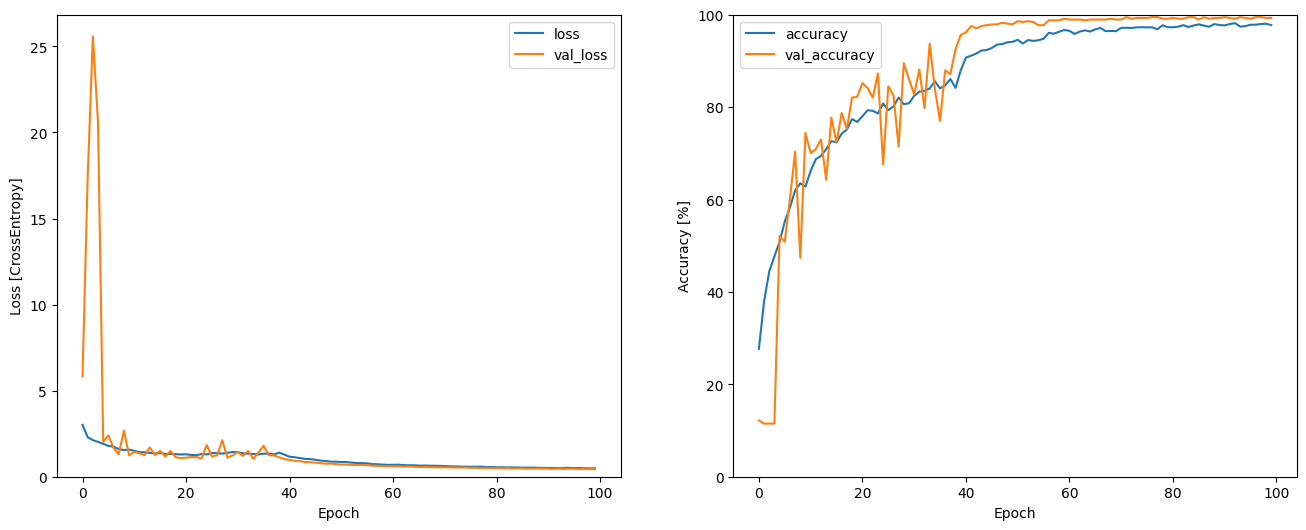

In [28]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [29]:
model.evaluate(test_spectrogram_ds, return_dict=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9825 - loss: 0.5443


{'accuracy': 0.9733096361160278, 'loss': 0.6158511638641357}

In [30]:
y_pred = model.predict(test_spectrogram_ds)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [31]:
y_pred = tf.argmax(y_pred, axis=1)

In [32]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

2024-05-07 17:27:05.599027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


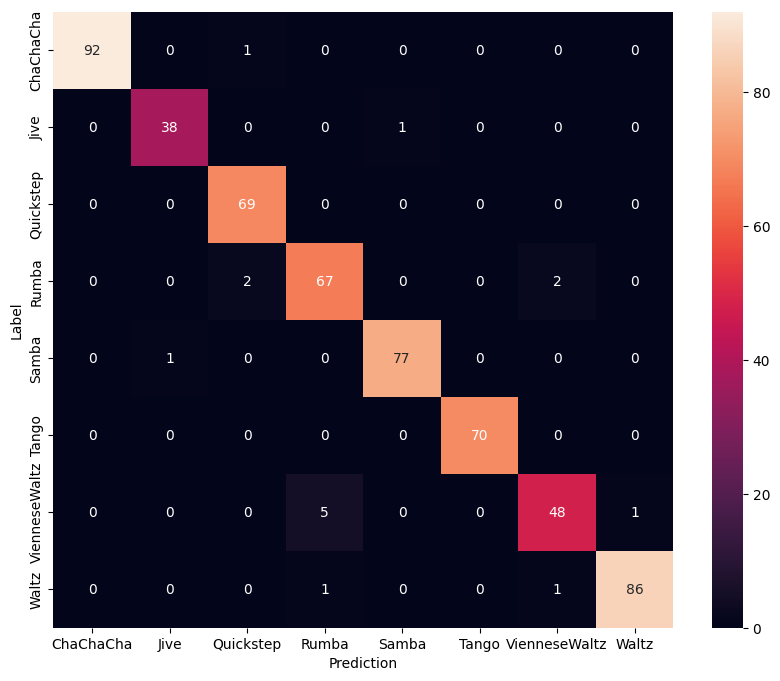

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Aggregating Predictions

- `Averaging Probabilities` is useful when you want to consider the contribution of each chunk equally. This method involves averaging the softmax probabilities of each chunk and then taking the class with the highest average probability as the final prediction.

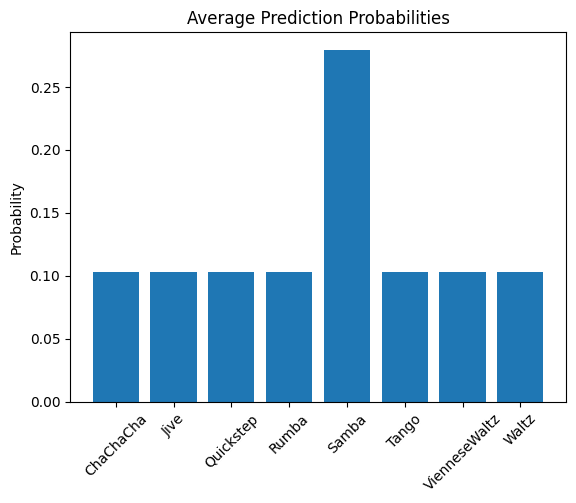

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa

def split_audio(audio, sample_rate, chunk_duration=5):
    # Calculate the number of samples in each chunk
    chunk_size = sample_rate * chunk_duration
    # Number of chunks
    num_chunks = len(audio) // chunk_size
    # Split the audio
    return tf.reshape(audio[:num_chunks * chunk_size], (num_chunks, chunk_size))

def predict_audio_chunks(model, audio_chunks):
    predictions = []
    for chunk in audio_chunks:
        # Preprocess the chunk (e.g., get spectrogram)
        spectrogram = get_spectrogram(chunk)
        spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimension
        # Predict
        pred = model(spectrogram, training=False)
        predictions.append(pred)
    return predictions

# Load and preprocess the audio file
x = './wavfiles/Samba/Albums-AnaBelen_Veneo-02.wav'
audio_binary = tf.io.read_file(x)
audio, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)

# Convert the tensor to numpy array
audio_np = audio.numpy().flatten()

# Resample the audio to 16000 Hz
audio_resampled = librosa.resample(audio_np, orig_sr=sample_rate.numpy(), target_sr=16000)

# Convert the numpy array back to tensor
audio_16k = tf.convert_to_tensor(audio_resampled, dtype=tf.float32)
sample_rate_16k = tf.constant(16000, dtype=tf.int32)

# Split the audio into 5-second chunks
audio_chunks = split_audio(audio_16k, sample_rate_16k.numpy())

# Predict each chunk
predictions = predict_audio_chunks(model, audio_chunks)

# Aggregate predictions (e.g., by averaging the probabilities)
# This example simply averages the softmax probabilities across all chunks
probabilities = tf.reduce_mean([tf.nn.softmax(pred[0]) for pred in predictions], axis=0)

# Plotting the probabilities for each class
plt.bar(label_names, probabilities.numpy())
plt.title('Average Prediction Probabilities')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

# Optionally, display the first chunk of the audio file for reference
display(Audio(audio_chunks[0].numpy(), rate=sample_rate.numpy()))

In [36]:
import tensorflow_io as tfio

class ExportModel(tf.Module):
    def __init__(self, model, sample_rate=16000):
        self.model = model
        self.sample_rate = sample_rate

    def process_results(self, result):
        # This function processes results and ensures all tensor operations are scoped correctly
        probabilities = tf.reduce_mean(result, axis=0)
        return probabilities

    def predict_audio_chunks(self, audio_chunks):
        num_chunks = tf.shape(audio_chunks)[0]
        predictions = tf.TensorArray(dtype=tf.float32, size=num_chunks)
        for i in tf.range(num_chunks):
            chunk = audio_chunks[i][tf.newaxis, :]
            spectrogram = get_spectrogram(chunk)
            pred = self.model(spectrogram, training=False)
            predictions = predictions.write(i, tf.nn.softmax(pred[0]))
        return predictions.stack()

    def split_audio(self, audio, sample_rate, chunk_duration=5):
        # Calculate the number of samples in each chunk
        chunk_size = sample_rate * chunk_duration
        # Number of chunks
        num_chunks = len(audio) // chunk_size
        # Split the audio
        return tf.reshape(
            audio[: num_chunks * chunk_size], (num_chunks, chunk_size)
        )

    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it.
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, sample_rate = tf.audio.decode_wav(x, desired_channels=1)

            # Ensure the audio is mono
            if x.shape[1] > 1:
                x = tf.reduce_mean(x, axis=1)
            # Resample the audio to 16000 Hz if necessary
            if sample_rate != self.sample_rate:
                x = tfio.audio.resample(x, rate_in=tf.cast(sample_rate, tf.int64), rate_out=self.sample_rate)
            # Split the audio into 5-second chunks
            audio_chunks = self.split_audio(x, self.sample_rate)
        else:
            audio_chunks = self.split_audio(x, self.sample_rate)

        # Predict each chunk and process results
        result = self.predict_audio_chunks(audio_chunks)
        probabilities = self.process_results(result)
        class_ids = tf.argmax(probabilities, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {
            "predictions": probabilities,
            "class_ids": class_ids,
            "class_names": class_names,
        }

In [37]:
label_names

array(['ChaChaCha', 'Jive', 'Quickstep', 'Rumba', 'Samba', 'Tango',
       'VienneseWaltz', 'Waltz'], dtype='<U13')

In [39]:
export = ExportModel(model)
export(tf.constant('./wavfiles/Samba/Albums-AnaBelen_Veneo-02.wav'))

{'predictions': <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([0.10372569, 0.10484403, 0.10458644, 0.10627389, 0.26986587,
        0.10356728, 0.10356945, 0.10356736], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 'class_names': <tf.Tensor: shape=(), dtype=string, numpy=b'Samba'>}

In [40]:
x = './wavfiles/Quickstep/Albums-AnaBelen_Veneo-11.wav'

tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
predictions = imported(x)

predictions

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([0.13180296, 0.10310117, 0.25028327, 0.10294387, 0.10303489,
        0.10294688, 0.10294341, 0.10294356], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 'class_names': <tf.Tensor: shape=(), dtype=string, numpy=b'Quickstep'>}